In [1]:
import collections
import numpy as np
import pandas as pd
import re
import glob
import json

%matplotlib inline
import matplotlib.pyplot as plt

from argparse import Namespace

from torchtext.utils import download_from_url, extract_archive

Download the data from the [here](https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ).   

Extract it to the folder called `.data`

In [2]:
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv=".data/faq_with_splits.csv",
    output_processed_csv_prefix=".data/faq_with_splits_",
    seed=1234,
    min_questions_per_category=3000
)

In [3]:
def find_files(path):
    return glob.glob(path)

def read_json(filename):
    with open(filename, encoding='utf-8', errors='ignore') as json_file:
        data = json.load(json_file)
    return data

In [4]:
frames = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    frames.append(pd.DataFrame(read_json(file)))
    
faq = pd.concat(frames).reset_index(drop=True)

Reading file: .data\gyakori_allatok_14000
Reading file: .data\gyakori_egeszseg
Reading file: .data\gyakori_egeszseg_20000
Reading file: .data\gyakori_szamitastechnika
Reading file: .data\gyakori_szorakozas_30000


In [5]:
faq.head()

,rovid_kerdes,hosszu_kerdes,valasz,kategoriak,keywords
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,"[Állatok, Kutyák]","[kutya, őrkutya, aktív]"
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,"[Állatok, Egyéb kérdések]","[állatorvos, időpont]"
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...","[Állatok, Kutyák]","[husky, kutya, cica, összeszoktatás]"
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,"[Állatok, Kutyák]","[kutya, betegség, szem, állat, orvos]"
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,"[Állatok, Kutyák]","[vadászat, vizsla, kutya, állat, vad, lövés, p..."


In [6]:
faq.rename(columns = {
        "valasz": "answer",
        "kategoriak": "categories",
        "hosszu_kerdes": "long_question",
        "rovid_kerdes": "short_question"
    }, inplace = True)

In [7]:
faq['main_category'] = faq.apply(lambda row: row.categories[0], axis = 1)
faq['sub_category'] = faq.apply(lambda row: row.categories[1], axis = 1)

In [8]:
faq = faq.drop('keywords', axis = 1)
faq = faq.drop('categories', axis = 1)

In [9]:
faq.head()

,short_question,long_question,answer,main_category,sub_category
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,Állatok,Kutyák
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák


In [10]:
faq[faq.short_question.str.contains('\r')]

,short_question,long_question,answer,main_category,sub_category
153117,Tényleg ez történik a Star Wars-ban?\r\n\r\nSP...,Tényleg ez történik a Star Wars-ban?\r \r SPOI...,"Azert most mar jo ideje kint van a film, unnep...",Szórakozás,"Filmek, sorozatok"


In [11]:
def clear_escaped_characters(text):
    text = text.replace('\n', ' ')
    return text.replace('\r', ' ')

In [12]:
faq.long_question = faq.long_question.apply(lambda x: clear_escaped_characters(x))
faq.short_question = faq.short_question.apply(lambda x: clear_escaped_characters(x))
faq.answer = faq.answer.apply(lambda x: clear_escaped_characters(x))

In [13]:
faq = faq[~faq.long_question.str.contains('\[link\]') & ~faq.answer.str.contains('\[link\]')]

In [14]:
categories = set(faq.main_category)
print(categories)

{'Szórakozás', 'Gyerekvállalás, nevelés', 'Állatok', 'Egészség', 'Számítástechnika'}


In [15]:
def number_of_questions_by_category():
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('Kérdések száma kategóriánként')

    grouped_faq = faq.groupby(faq.main_category)
    data_to_plot = grouped_faq.size().sort_values()

    data_to_plot.plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
    data_to_plot.plot(kind='bar', ax=ax[1])

    y_axis_0 = ax[0].axes.get_yaxis()
    y_axis_0.set_visible(False)

    ax[1].set_xlabel("")
    ax[1].bar_label(ax[1].containers[0])
    
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(0)

    plt.show()

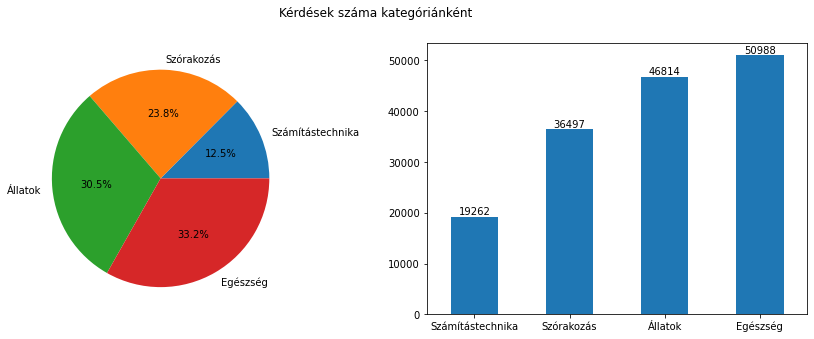

In [104]:
number_of_questions_by_category()

In [17]:
for category in categories:
    category_size = faq[faq.main_category == category].shape[0]
    if category_size < args.min_questions_per_category:
        faq = faq[faq.main_category != category]

In [24]:
categories = set(faq.main_category)

In [25]:
def add_splits(df):
    by_main_category = collections.defaultdict(list)

    for _, row in df.iterrows():
        by_main_category[row.main_category].append(row.to_dict())
        
    final_list = []
    np.random.seed(args.seed)

    for _, item_list in sorted(by_main_category.items()):
        np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(args.train_proportion * n)
        n_val = int(args.val_proportion * n)
        n_test = int(args.test_proportion * n)

        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train+n_val]:
            item['split'] = 'val'
        for item in item_list[n_train+n_val:]:
            item['split'] = 'test'  

        final_list.extend(item_list)
    return final_list

In [26]:
list_with_splits = add_splits(faq)

In [27]:
faq_with_splits = pd.DataFrame(list_with_splits)

In [28]:
faq_with_splits.head()

,short_question,long_question,answer,main_category,sub_category,split
0,Hogyan enyhítsek a stresszen?,Hogyan enyhítsek a stresszen? Idén fogok felvé...,Relaxációs technikák alkalmazása lenne jó: ado...,Egészség,Egyéb kérdések,train
1,Nektek hány napig tartott az első menstruációtok?,Nektek hány napig tartott az első menstruációtok?,Kb 3-4 napig.,Egészség,Nők egészsége,train
2,Mennyi idő alatt gyógyul be?,Mennyi idő alatt gyógyul be? Ma volt délben eg...,Nyalogasd mint a kutya :),Egészség,Férfiak egészsége,train
3,SOS! Ha a vesémmel van gond a laborba vért is ...,SOS! Ha a vesémmel van gond a laborba vért is ...,Kell. A vérvizsgálatnak is vannak olyan részei...,Egészség,Egészségügyi ellátások,train
4,"13 eves vagyok.60A a mellem, de az osztaly tar...","13 eves vagyok.60A a mellem, de az osztaly tar...",te jó isten ki nem sz*ja le hogy a másiknak me...,Egészség,Nők egészsége,train


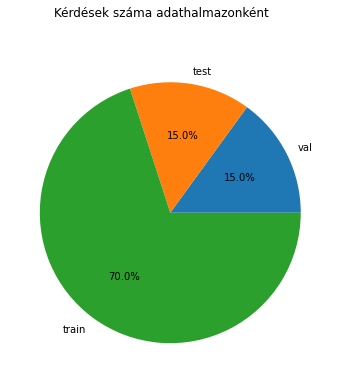

In [29]:
fig, ax = plt.subplots(1, figsize=(10, 6))

fig.suptitle('Kérdések száma adathalmazonként')
data_to_plot = faq_with_splits.groupby(faq_with_splits.split).size().sort_values()

data_to_plot.plot(kind='pie', ax=ax, autopct='%1.1f%%')

y_axis_0 = ax.axes.get_yaxis()
y_axis_0.set_visible(False)

plt.show()

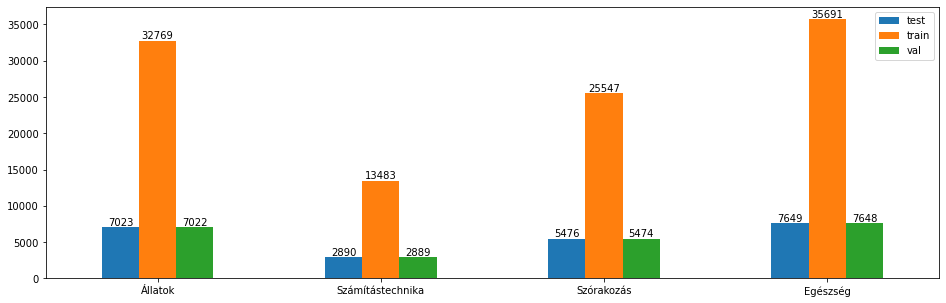

In [72]:
fig, ax = plt.subplots(1, figsize=(16, 5))

splits = list(set(faq_with_splits.split))

index = categories
questions_in = {}

for split in splits:
    questions_in[split] = []
    faq_split = faq_with_splits[faq_with_splits.split == split]
    
    for category in categories:
        questions_in[split].append(faq_split[faq_split.main_category == category].shape[0])

df = pd.DataFrame({split: questions_in[split] for split in splits}, index=index)        
df.head()

df.plot(kind='bar',ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

In [62]:
from unidecode import unidecode

def unicode_to_ascii(data):
    return unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower(), errors='ignore')

ascii_faq = faq_with_splits.copy()

ascii_faq.long_question = ascii_faq.long_question.apply(lambda x: unicode_to_ascii(x))
ascii_faq.short_question = ascii_faq.short_question.apply(lambda x: unicode_to_ascii(x))
ascii_faq.answer = ascii_faq.answer.apply(lambda x: unicode_to_ascii(x))

C:\Users\User\anaconda3\lib\site-packages\unidecode\__init__.py:131: RuntimeWarning: Surrogate character '\ud83d' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
C:\Users\User\anaconda3\lib\site-packages\unidecode\__init__.py:131: RuntimeWarning: Surrogate character '\ude0f' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)


In [32]:
ascii_faq.head()

,short_question,long_question,answer,main_category,sub_category,split
0,hogyan enyhitsek a stresszen,hogyan enyhitsek a stresszen iden fogok felvet...,relaxacios technikak alkalmazasa lenne jo: ado...,Egészség,Egyéb kérdések,train
1,nektek hany napig tartott az elso menstruaciotok,nektek hany napig tartott az elso menstruaciotok,kb 3-4 napig,Egészség,Nők egészsége,train
2,mennyi ido alatt gyogyul be,mennyi ido alatt gyogyul be ma volt delben egy...,nyalogasd mint a kutya :),Egészség,Férfiak egészsége,train
3,sos ha a vesemmel van gond a laborba vert is v...,sos ha a vesemmel van gond a laborba vert is v...,kell a vervizsgalatnak is vannak olyan reszei ...,Egészség,Egészségügyi ellátások,train
4,13 eves vagyok 60a a mellem de az osztaly tars...,13 eves vagyok 60a a mellem de az osztaly tars...,te jo isten ki nem sz*ja le hogy a masiknak me...,Egészség,Nők egészsége,train


In [33]:
ascii_faq.split.value_counts()

train    107490
test      23038
val       23033
Name: split, dtype: int64

In [34]:
ascii_faq.to_csv(args.output_munged_csv, index=False)

### Lemmatization, stemming, stop-word filtering

In [63]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import HungarianStemmer
from nltk.corpus import stopwords

import nltk

import hu_core_ud_lg

In [36]:
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('hungarian'))

In [37]:
tokenizer = RegexpTokenizer(r'\w+')

stemmer = HungarianStemmer()

question = faq_with_splits.iloc[2]['long_question']

# Tokenization
tokenized_sentence = tokenizer.tokenize(question)

# Stopword filtering
filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]

# Lemmatization
lemmatizer = hu_core_ud_lg.load()

lemmatizer.remove_pipe('parser')
lemmatizer.remove_pipe('ner')
lemmatizer.add_pipe(lemmatizer.create_pipe('sentencizer'))

doc = lemmatizer(" ".join(filtered_sentence))

In [38]:
print(f"Original question:\n{question}\n")

print("After tokenization:")
for w in tokenized_sentence:
    print(w, end=" ")

print("\n\nAfter stopword filtering:")
for w in filtered_sentence:
    print(w, end=" ")

print("\n\nAfter lemmatization:")
for w in doc:
    print(w.lemma_.lower(), end=" ")
    
print("\n\nAfter stemming:")
for w in tokenized_sentence:
    print(stemmer.stem(w), end=" ")

Original question:
Mennyi idő alatt gyógyul be? Ma volt délben egy fityma fék műtétem kb 15 percet vett igénybe csak egy kis lézeres műtét volt semmi szike , ez mennyi alatt gyógyul meg ,egyenlőre még meg se néztem (nem húztam hátra a fitymát) rakott a doki rá kötést hogyha esetleg vérezne így 2 óra elteltével sem vérzett , maszturbálás és nemi élet az mennyi idő múlva lehetséges ?

After tokenization:
Mennyi idő alatt gyógyul be Ma volt délben egy fityma fék műtétem kb 15 percet vett igénybe csak egy kis lézeres műtét volt semmi szike ez mennyi alatt gyógyul meg egyenlőre még meg se néztem nem húztam hátra a fitymát rakott a doki rá kötést hogyha esetleg vérezne így 2 óra elteltével sem vérzett maszturbálás és nemi élet az mennyi idő múlva lehetséges 

After stopword filtering:
Mennyi idő gyógyul Ma délben fityma fék műtétem kb 15 percet vett igénybe kis lézeres műtét szike mennyi gyógyul egyenlőre se néztem húztam hátra fitymát rakott doki kötést hogyha esetleg vérezne 2 óra elteltév

In [39]:
import time

In [40]:
def tokenize_question(question):
    tokenized = tokenizer.tokenize(question)
    return " ".join(tokenized)

In [41]:
def lemmatize_question(question):
    doc = lemmatizer(question)
    lemmatized = [w.lemma_.lower() for w in doc]
    return " ".join(lemmatized)

In [42]:
def stem_question(question):
    stemmed = [stemmer.stem(w) for w in question.split()]
    return " ".join(stemmed)

In [43]:
def filter_question(question):
    tokenized_question = " ".join(tokenizer.tokenize(question))
    filtered = [w for w in tokenized_question.split() if not w in stop_words]

    return " ".join(filtered)

In [44]:
def create_dataset(questions, func, name):
    result = []

    start_time = int(time.time() * 1000)
       
    for idx, q in enumerate(questions):
        result.append(func(q))
    
    end_time = int(time.time() * 1000)
    print(f"Creating dataset called '{name}' took: {(end_time - start_time) / 1000.0} seconds")
    
    return result

In [45]:
def create_datasets(questions):
    result = {}
    
    result['tokenized'] = create_dataset(questions, tokenize_question, "tokenized")
    
    result['stemmed'] = create_dataset(questions, stem_question, "stemmed")
    result['lemmatized'] = create_dataset(questions, lemmatize_question, "lemmatized")
    
    result['filtered'] = create_dataset(questions, filter_question, "filtered")
    
    result['stemmed_filtered'] = create_dataset(result['filtered'], stem_question, "stemmed_filtered")
    result['lemmatized_filtered'] = create_dataset(result['filtered'], lemmatize_question, "lemmatized_filtered")
    
    return result

In [46]:
short_questions = faq_with_splits['short_question'].tolist()
long_questions = faq_with_splits['long_question'].tolist()

In [64]:
short_questions_datasets = create_datasets(short_questions)

Creating dataset called 'tokenized' took: 0.489 seconds
Creating dataset called 'stemmed' took: 24.522 seconds
Creating dataset called 'lemmatized' took: 251.592 seconds
Creating dataset called 'filtered' took: 0.8 seconds
Creating dataset called 'stemmed_filtered' took: 17.811 seconds
Creating dataset called 'lemmatized_filtered' took: 220.617 seconds


In [65]:
long_questions_datasets = create_datasets(long_questions)

Creating dataset called 'tokenized' took: 2.308 seconds
Creating dataset called 'stemmed' took: 129.136 seconds
Creating dataset called 'lemmatized' took: 521.594 seconds
Creating dataset called 'filtered' took: 3.677 seconds
Creating dataset called 'stemmed_filtered' took: 89.123 seconds
Creating dataset called 'lemmatized_filtered' took: 393.638 seconds


In [73]:
dataset_keys = list(short_questions_datasets.keys())

In [74]:
dataframes = {}
for key in dataset_keys:
    dataframe = faq_with_splits.copy()
    
    dataframe['short_question'] = short_questions_datasets[key]
    dataframe['long_question'] = long_questions_datasets[key]

    dataframes[key] = dataframe

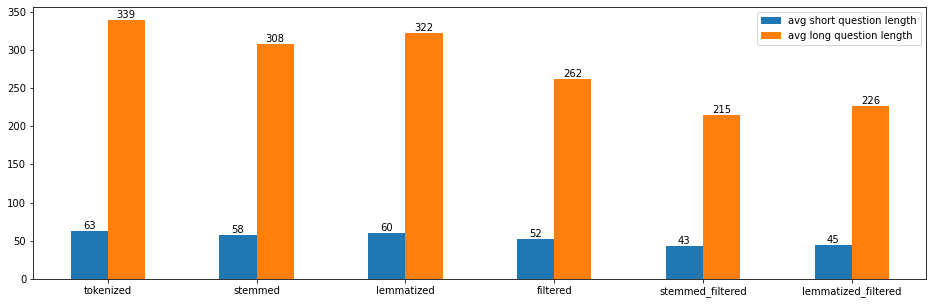

In [107]:
fig, ax = plt.subplots(1, figsize=(16, 5))

index = dataset_keys
short_len = []
long_len = []
for key in dataset_keys:
    long_len.append(round(dataframes[key].long_question.str.len().mean()))
    short_len.append(round(dataframes[key].short_question.str.len().mean()))

df = pd.DataFrame({'avg short question length': short_len, 'avg long question length': long_len}, index=index)        

df.plot(kind='bar', ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

In [180]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Írnátok biztatót,Írnátok biztatót Miután pár napja tűnt sikerül...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,Vehetek antidepresszánssal időben nyugtatót,Vehetek antidepresszánssal időben nyugtatót An...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,Azt halottam tüdőgyulladással feküdni Vese gyu...,Azt halottam tüdőgyulladással feküdni Vese gyu...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,Mit csináljak ha szekál osztályom miatt beteg ...,Mit csináljak ha szekál osztályom miatt beteg ...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,Hirtelen erős vérzésem percről másikra ömleni ...,Hirtelen erős vérzésem percről másikra ömleni ...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [181]:
dataframes['stemmed'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát nek valam biztatót?,írnát nek valam biztatót? miut pár nap úgy tűn...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet be az antidepresszáns egy idő nyugtatót?,vehet be az antidepresszáns egy idő nyugtatót?...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás nem nagy kell feküdni....,az halott tüdőgyulladás nem nagy kell feküdni....,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,"mi csináljak, ha szekál az osztály a miatt, ho...","mi csináljak, ha szekál az osztály a miatt, ho...","Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,"hirtel nagy erős let a vérzésem, egy percről a...","hirtel nagy erős let a vérzésem, egy percről a...",Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [182]:
dataframes['lemmatized'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnátok nek valami biztató ?,írnátok nek valami biztató ? miután pár nap úg...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet be az antidepresszáns egy idő nyugtató ?,vehet be az antidepresszáns egy idő nyugtató ?...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halik tüdőgyulladás nem nagyon kell fekszik...,az halik tüdőgyulladás nem nagyon kell fekszik...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,"mi csinál , ha szekál az osztály a miatt , hog...","mi csinál , ha szekál az osztály a miatt , hog...","Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,"hirtelen nagyon erős lett a vérzésem , egyik p...","hirtelen nagyon erős lett a vérzésem , egyik p...",Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [183]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Írnátok biztatót,Írnátok biztatót Miután pár napja tűnt sikerül...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,Vehetek antidepresszánssal időben nyugtatót,Vehetek antidepresszánssal időben nyugtatót An...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,Azt halottam tüdőgyulladással feküdni Vese gyu...,Azt halottam tüdőgyulladással feküdni Vese gyu...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,Mit csináljak ha szekál osztályom miatt beteg ...,Mit csináljak ha szekál osztályom miatt beteg ...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,Hirtelen erős vérzésem percről másikra ömleni ...,Hirtelen erős vérzésem percről másikra ömleni ...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [184]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát biztató,írnát biztató miut pár nap tűnt siker kilábaln...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás feküdn ves gyulladás m...,az halott tüdőgyulladás feküdn ves gyulladás m...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinálj ha szekál osztály miat beteg hiányz,mi csinálj ha szekál osztály miat beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtel erős vérzés percről más ömlen kezdet ré...,hirtel erős vérzés percről más ömlen kezdet ré...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [185]:
dataframes['lemmatized_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnátok biztató,írnátok biztató miután pár nap tűnik sikerül k...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halik tüdőgyulladás fekszik vese gyulladás ...,az halik tüdőgyulladás fekszik vese gyulladás ...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinál ha szekál osztály miatt beteg hiányzik,mi csinál ha szekál osztály miatt beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtelen erős vérzésem perc másikra ömlik kezd...,hirtelen erős vérzésem perc másikra ömlik kezd...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [186]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát biztató,írnát biztató miut pár nap tűnt siker kilábaln...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás feküdn ves gyulladás m...,az halott tüdőgyulladás feküdn ves gyulladás m...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinálj ha szekál osztály miat beteg hiányz,mi csinálj ha szekál osztály miat beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtel erős vérzés percről más ömlen kezdet ré...,hirtel erős vérzés percről más ömlen kezdet ré...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [187]:
for dataframe_key in dataframes:
    filename = f"{args.output_processed_csv_prefix}{dataframe_key}.csv"
    print(f"Creating {filename}")
    dataframes[dataframe_key].to_csv(filename, index=False, encoding='utf-8', errors='ignore')

Creating .data/faq_with_splits_tokenized.csv
Creating .data/faq_with_splits_stemmed.csv
Creating .data/faq_with_splits_lemmatized.csv
Creating .data/faq_with_splits_filtered.csv
Creating .data/faq_with_splits_stemmed_filtered.csv
Creating .data/faq_with_splits_lemmatized_filtered.csv
